# Load Data

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

,volume
Date,
2016-01-04,6886
2016-01-05,4928
2016-01-06,3713
2016-01-07,3910
2016-01-08,3797


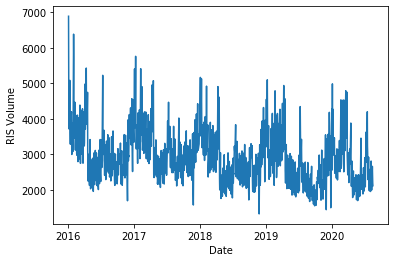

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/majickdave/dji_vol/master/dji.csv', 
                 header=1, 
                 usecols=[1,4], parse_dates=['Date'], index_col=['Date']
                )
df.columns = ['volume']
display(df.head())
plt.xlabel('Date')
plt.ylabel('RIS Volume')
plt.plot(df)

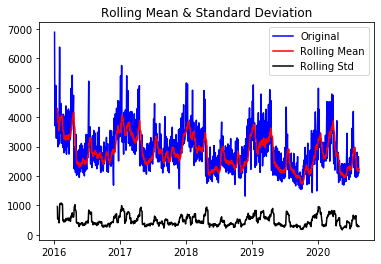

ADF Statistic: -4.13845106658161
p-value: 0.0008360976668759317
Critical Values:
	1%: -3.4361194876415078
	5%: -2.8640875863904105
	10%: -2.5681264020345664


In [21]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['volume'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(df)

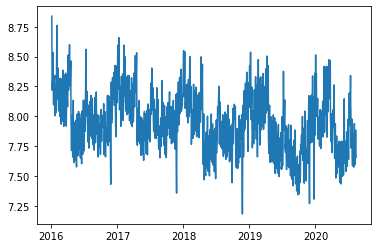

In [23]:
df_log = np.log(df)
plt.plot(df_log)

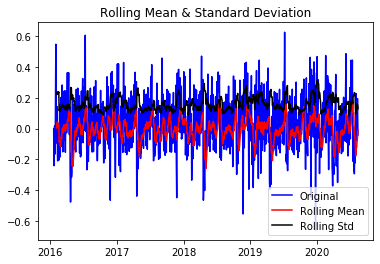

ADF Statistic: -6.6578382324003265
p-value: 4.932499076869147e-09
Critical Values:
	1%: -3.4361760299117914
	5%: -2.8641125290596436
	10%: -2.5681396861234567


In [24]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

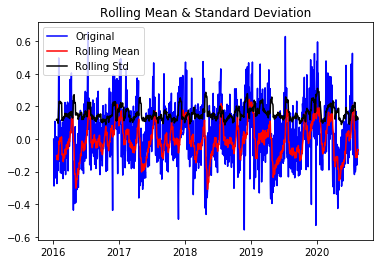

ADF Statistic: -5.332482320087921
p-value: 4.6881052105468946e-06
Critical Values:
	1%: -3.4361194876415078
	5%: -2.8640875863904105
	10%: -2.5681264020345664


In [25]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

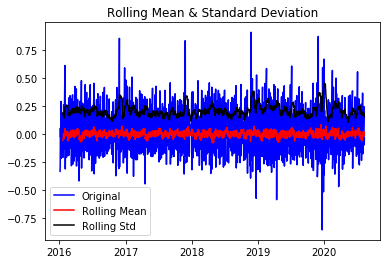

ADF Statistic: -8.376706267709599
p-value: 2.5745763837312937e-13
Critical Values:
	1%: -3.4361245824564977
	5%: -2.8640898339013243
	10%: -2.56812759902191


In [26]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [27]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [43]:
df.index.resample('H')

AttributeError: 'DatetimeIndex' object has no attribute 'resample'

# Create Training Data and Fit Model

In [184]:
df = df[['Date','RIS Actual Volume']]

#  pre-format for prophet
df.columns = ['ds','y']

# set start date of training data
df = df[df['ds'] >= '2018-07-01']
df.head()

,ds,y
628,2018-07-02,2890
629,2018-07-03,2190
630,2018-07-05,2460
631,2018-07-06,2440
632,2018-07-09,3225


In [185]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True)
m.fit(df)

# Create future dates

In [186]:
future = m.make_future_dataframe(periods=100)
future.tail()

,ds
627,2020-11-17
628,2020-11-18
629,2020-11-19
630,2020-11-20
631,2020-11-21


# Make Predicitons on future dates

In [187]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
627,2020-11-17,2313.120861,1869.017938,2770.140216
628,2020-11-18,2126.470353,1651.489755,2595.298059
629,2020-11-19,2043.115137,1577.889031,2526.460139
630,2020-11-20,2139.503742,1635.922861,2608.826688
631,2020-11-21,2367.576351,1902.185342,2910.686041


# Visualize seasonality and analyze trends

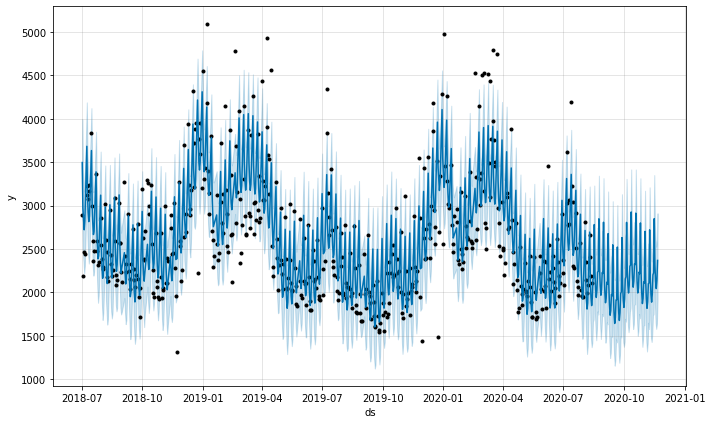

In [188]:
fig1 = m.plot(forecast)

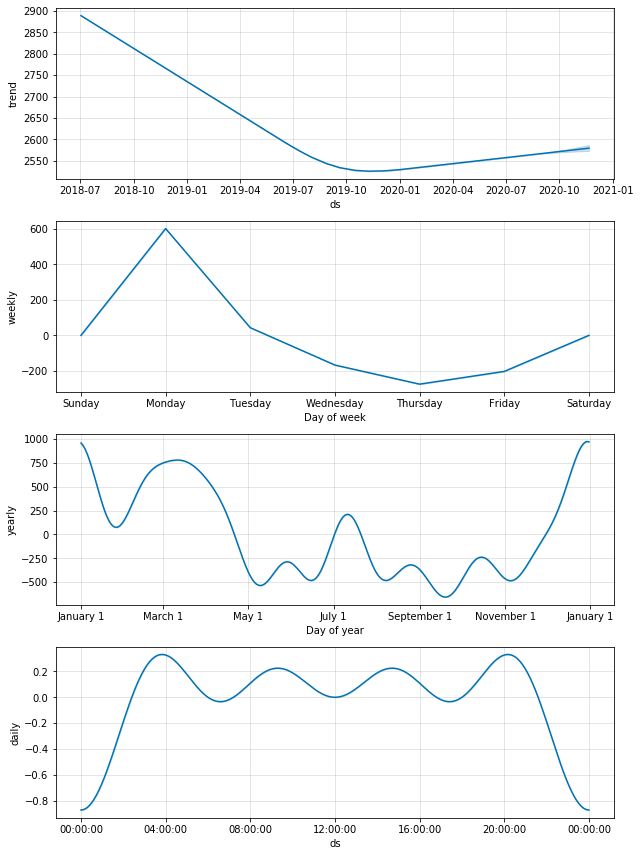

In [189]:
fig2 = m.plot_components(forecast)

# Calculate metrics for original model and prophet 
from dates 2020-8-17 through 2020-10-13

In [190]:
## Load current volume and forecast

df2 = pd.read_csv('ris_forecast.csv', usecols=[0,1,2,3])
df2['date'] = pd.to_datetime(df2['date'])
df2.head()

,date,RECEIVED,FORECAST,HANDLED
0,2020-08-17,2404,2542,2274
1,2020-08-18,1922,2057,1764
2,2020-08-19,1926,1874,1779
3,2020-08-20,1769,1790,1724
4,2020-08-21,1933,1842,1643


In [191]:
# create forecast window
f = forecast[(forecast['ds']>='2020-08-17') & (
    forecast['ds']<'2020-10-14')][['ds','yhat', 'yhat_lower', 'yhat_upper']]

# get rid of holiday and weekend
f = f[~f['ds'].dt.weekday.isin([5,6])]

# drop labor day 2020
f = f[f['ds']!='2020-09-07']

In [245]:
def validate_dates(f, df2):
    """
    take in forecast, f
    and dataframe df2 and return Bool
    """
    res = []
    # validate forecast dates shape equals actual dates shape
    v1 = df2.shape[0] == f.shape[0]
    if not v1:
        return False
    else: res.append(v1)
        
    # validate all dates for forecast equal actual dates
    res.append(all(df2['date'].dt.date.values == f['ds'].dt.date.values))
    
    return all(res)

print(validate_dates(f, df2))

True


In [193]:
# join actual and current forecast to dataframe f
f['actual'] = df2['RECEIVED'].values

f['forecast'] = df2['FORECAST'].values

In [248]:
def get_error(f, metric='MAPE'):
    """
    take in a dataframe f, of predictions, y_hat,
    and a list of actuals, y and return
    a float
    metric can be ['MAPE', 'RMSE']
    """
    res = {}
    # Do MAPE calc
    if metric == 'MAPE':
        res['prophet'] = ((f['actual']-f['yhat'])/f['actual']).abs().sum()/f.shape[0] * 100
        res['forecast'] = ((f['actual']-f['forecast'])/f['actual']).abs().sum()/f.shape[0] * 100
    # Do RMSE calc
    elif metric == 'RMSE':
        res['prophet'] = (((f['yhat']-f['actual'])**2).sum()/f.shape[0])**.5
        res['forecast'] = (((f['forecast']-f['actual'])**2).sum()/f.shape[0])**.5
    # TODO any other metric calc
    else:
        return 'There is an error with the metric'
    
    return pd.DataFrame(res, index=[metric])

mape, rmse = get_error(f), get_error(f, metric='RMSE')
display(mape)
display(rmse)

print(get_error(f, metric=1))

,prophet,forecast
MAPE,7.409237,8.212873


,prophet,forecast
RMSE,225.427702,234.795448


There is an error with the metric


In [241]:
((mape['forecast'] - mape['prophet']).values[0]/100 * f['actual']).mean()

17.06787128129803

## Both MAPE and RMSE are lower for the prophet model

this could result in a daily forecast accuracy improvement of about 17 calls per day for RIS group. 

# Future Work

1. determine most important metric for forecasting in each business unit
    - tune hyperparameters of prophet model
    - create different training, validation, and testing datasets (changing windows of time)

2. Create forecasts for handle time
    - repeat step 1

3. Create forecasts for other KPIs
    - repeat step 1
4. Test other time series models like ARIMA
5. Test Neural Networks (LSTM)
